In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Define the path to your dataset folder
dataset_folder = 'data/'

# Define image dimensions
image_width, image_height = 224, 224

# Define the class labels
class_labels = ['UPJ_obstruction', 'Normal']

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_width, image_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Collect all image paths and labels
image_paths = []
labels = []
for label in class_labels:
    class_folder = os.path.join(dataset_folder, label)
    class_index = class_labels.index(label)
    for img in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img))
        labels.append(class_index)

# Split data into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CustomDataset(X_train_paths, y_train, transform=transform)
test_dataset = CustomDataset(X_test_paths, y_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Choose the base model (VGG16, InceptionV3, or DenseNet121)
base_model_name = 'VGG16'  # Change this to 'InceptionV3' or 'DenseNet121' to use a different base model

# Load the pre-trained base model
if base_model_name == 'VGG16':
    base_model = models.vgg16(pretrained=True)
    base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude the fully connected layers
    num_filters = 512
elif base_model_name == 'InceptionV3':
    base_model = models.inception_v3(pretrained=True)
    base_model = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the fully connected layers
    num_filters = 2048
elif base_model_name == 'DenseNet121':
    base_model = models.densenet121(pretrained=True)
    base_model = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the fully connected layers
    num_filters = 1024
else:
    raise ValueError("Invalid base model name. Choose from 'VGG16', 'InceptionV3', or 'DenseNet121'.")

# Freeze the weights of the base model
for param in base_model.parameters():
    param.requires_grad = False

# Define additional layers
class CustomModel(nn.Module):
    def __init__(self, base_model, num_filters, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.conv1 = nn.Conv2d(num_filters, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = CustomModel(base_model, num_filters, len(class_labels))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomModel(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.5813, Accuracy: 63.97%
Epoch 2/10, Loss: 0.3075, Accuracy: 91.54%
Epoch 3/10, Loss: 0.2358, Accuracy: 93.38%
Epoch 4/10, Loss: 0.1643, Accuracy: 93.75%
Epoch 5/10, Loss: 0.1510, Accuracy: 94.12%
Epoch 6/10, Loss: 0.1969, Accuracy: 94.12%
Epoch 7/10, Loss: 0.1535, Accuracy: 94.12%
Epoch 8/10, Loss: 0.1165, Accuracy: 94.12%
Epoch 9/10, Loss: 0.1140, Accuracy: 94.49%
Epoch 10/10, Loss: 0.1093, Accuracy: 96.32%


Test Loss: 0.8161, Test Accuracy: 91.18%, F1-score: 0.91


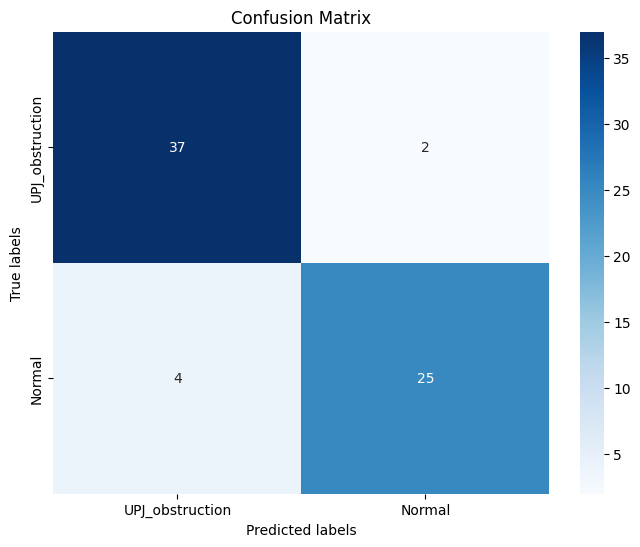

In [7]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1-score: {f1:.2f}')
    return all_labels, all_predictions

# Evaluate the model
all_labels, all_predictions = evaluate_model(model, test_loader, criterion)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
!pip install umap-learn

   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.7 kB ? eta -:--:--
   -------------------------------------- - 81.9/85.7 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 85.7/85.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.8 kB ? eta -:--:--
   ---------------------------------------- 56.8/56.8 kB 2.9 MB/s eta 0:00:00


In [13]:
pip install umap-learn[plot]

   ---------------------------------------- 0.0/260.3 kB ? eta -:--:--
   ---------------------------------------- 260.3/260.3 kB 8.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
   - -------------------------------------- 0.6/18.3 MB 13.5 MB/s eta 0:00:02
   --- ------------------------------------ 1.4/18.3 MB 18.0 MB/s eta 0:00:01
   ---- ----------------------------------- 2.1/18.3 MB 16.9 MB/s eta 0:00:01
   ----- ---------------------------------- 2.7/18.3 MB 15.6 MB/s eta 0:00:02
   ------- -------------------------------- 3.3/18.3 MB 16.3 MB/s eta 0:00:01
   -------- ------------------------------- 4.1/18.3 MB 16.3 MB/s eta 0:00:01
   ---------- ----------------------------- 4.8/18.3 MB 17.1 MB/s eta 0:00:01
   ------------ --------------------------- 5.8/18.3 MB 16.8 MB/s eta 0:00:01
   -------------- ------------------------- 6.6/18.3 MB 17.5 MB/s eta 0:00:01
   -------------- ------------------------- 6.8/18.3 MB 17.4 MB/s eta 0:00:01

C:\Users\Akshat\myenv\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
C:\Users\Akshat\myenv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


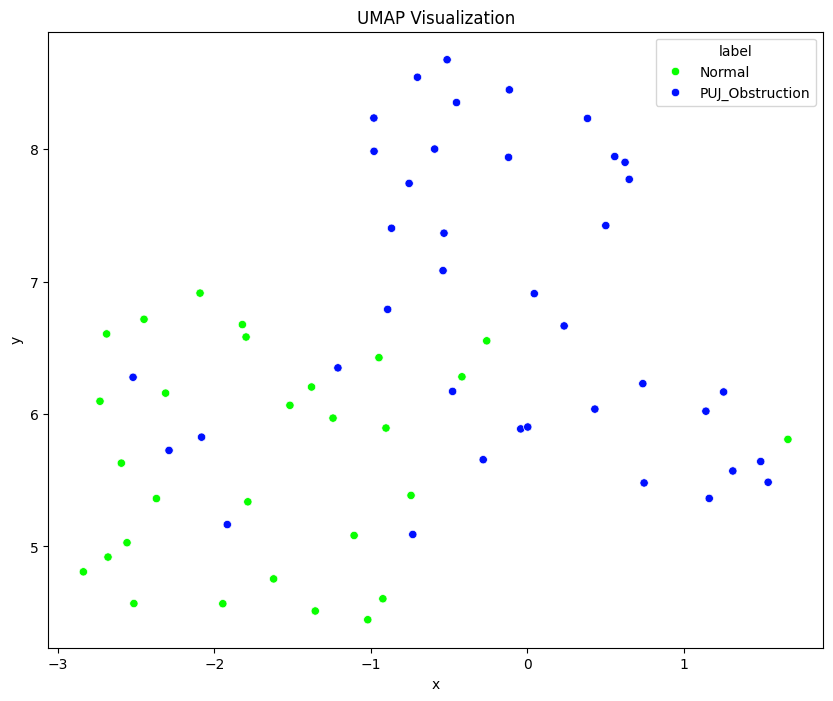

In [14]:
import umap
import umap.plot

# Extract features for UMAP visualization
model.eval()
features = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model.base_model(inputs)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten the outputs
        features.append(outputs.cpu().numpy())
features = np.concatenate(features, axis=0)

# Apply UMAP to visualize the feature embeddings
umap_model = umap.UMAP(n_components=2, random_state=42)
X_test_embedded = umap_model.fit_transform(features)

# Define a mapping dictionary for class labels
label_mapping = {0: 'PUJ_Obstruction', 1: 'Normal'}

# Map numerical labels to string representations
label_strings = [label_mapping[label] for label in y_test]

# Create DataFrame with string labels
df = pd.DataFrame({'x': X_test_embedded[:, 0], 'y': X_test_embedded[:, 1], 'label': label_strings})

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', palette=sns.color_palette('hsv', len(class_labels)), data=df, legend='full')
plt.title('UMAP Visualization')
plt.show()

In [15]:
pip install dask[dataframe]

   ---------------------------------------- 0.0/205.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/205.5 kB ? eta -:--:--
   ----- --------------------------------- 30.7/205.5 kB 262.6 kB/s eta 0:00:01
   ------------------------------- -------- 163.8/205.5 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 205.5/205.5 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


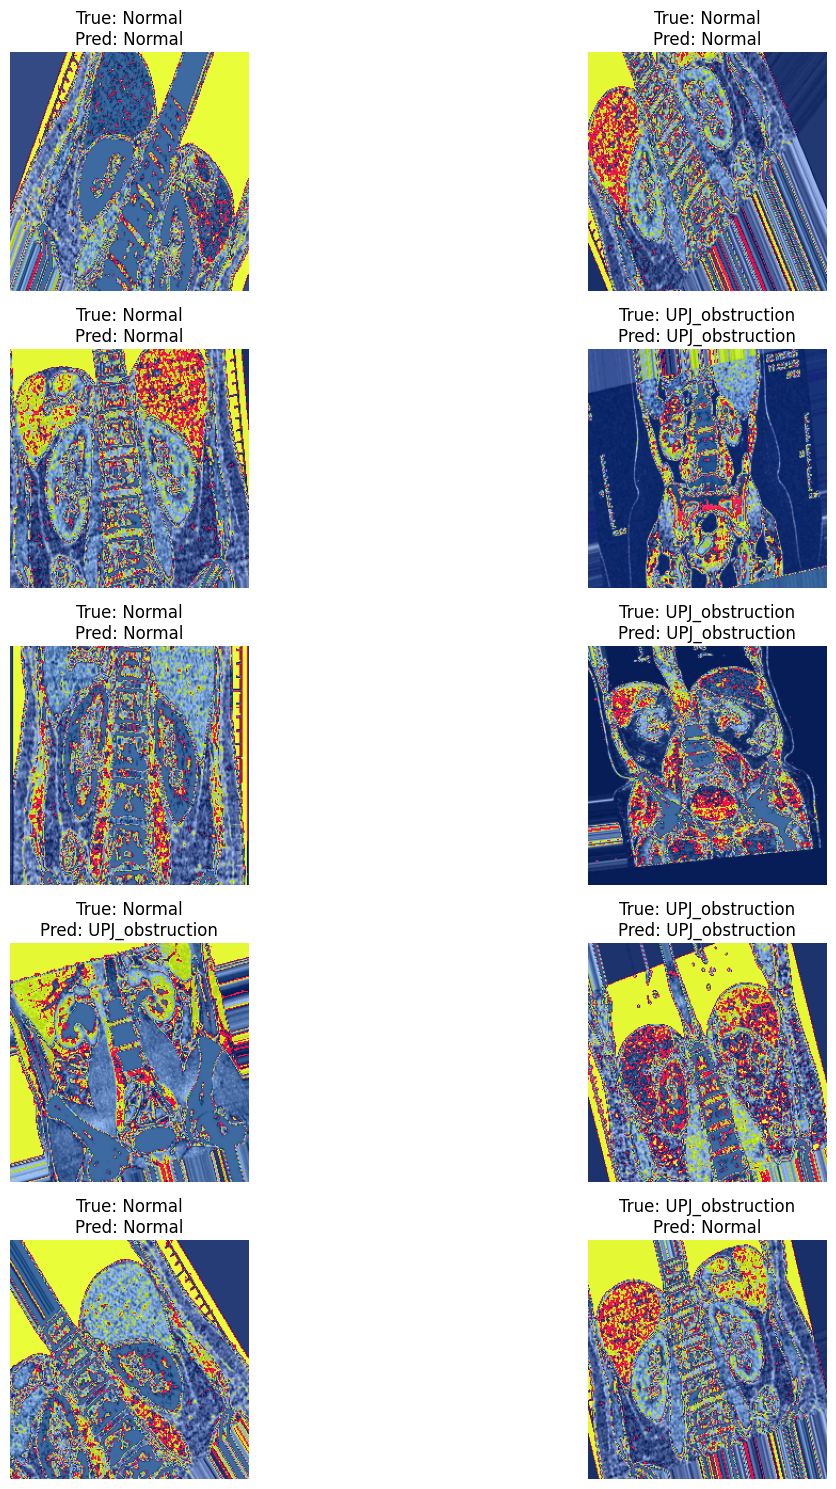

In [16]:
import matplotlib.pyplot as plt
import random

def show_predictions(model, test_dataset, class_labels, num_images=10):
    # Set the model to evaluation mode
    model.eval()
    
    # Randomly select images from the test set
    indices = random.sample(range(len(test_dataset)), num_images)
    
    # Prepare the figure
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        image = image.to(device).unsqueeze(0)
        
        with torch.no_grad():
            output = model(image)
            _, predicted_label = torch.max(output, 1)
        
        true_label = class_labels[true_label]
        predicted_label = class_labels[predicted_label.item()]
        
        # Convert the image tensor to numpy for display
        image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
        image = (image * 255).astype(np.uint8)
        
        # Display the image with true and predicted labels
        plt.subplot(num_images // 2, 2, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display images and their predictions
show_predictions(model, test_dataset, class_labels, num_images=10)